In [1]:
# 1. Import required modules/libraries
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall
from segmentation_models.metrics import IOUScore

2024-12-16 07:45:11.672663: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 07:45:11.679132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-16 07:45:11.686436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-16 07:45:11.688599: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-16 07:45:11.694540: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `tf.keras` framework.


In [2]:
# 2. Define Metrics
# Pixel Accuracy
def pixel_accuracy(y_true, y_pred):
    y_pred_binary = tf.round(y_pred)  # Convert logits to binary
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_binary), tf.float32))

# Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

# Initialize Precision and Recall as Keras metrics globally
precision_metric = Precision()
recall_metric = Recall()

def f1_score(y_true, y_pred):
    precision_value = precision_metric(y_true, y_pred)
    recall_value = recall_metric(y_true, y_pred)
    f1 = 2 * (precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon())
    return f1

I0000 00:00:1734324312.690276   22237 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734324312.707052   22237 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734324312.707088   22237 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734324312.709612   22237 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1734324312.709641   22237 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [3]:
# 3. Function to load images and labels
def load_images_and_labels(image_dir, label_dir, image_size=(288, 288)):
    images = []
    labels = []
    
    for image_name in sorted(os.listdir(image_dir)):
        # Load image and label
        img_path = os.path.join(image_dir, image_name)
        label_path = os.path.join(label_dir, image_name)
        
        image = img_to_array(load_img(img_path, target_size=image_size, color_mode='grayscale')) / 255.0
        label = img_to_array(load_img(label_path, target_size=image_size, color_mode='grayscale')) / 255.0
        
        images.append(image)
        labels.append(label)
        
    return np.array(images), np.array(labels)

In [4]:
# 4. Load datasets
train_images_dir = "data/train/image/"
train_labels_dir = "data/train/label/"

val_images_dir = "data/val/image/"
val_labels_dir = "data/val/label/"

test_images_dir = "data/test/image/"
test_labels_dir = "data/test/label/"

final_test_images_dir = "data/final_test/image/"
final_test_labels_dir = "data/final_test/label/"

train_images, train_labels = load_images_and_labels(train_images_dir, train_labels_dir)
val_images, val_labels = load_images_and_labels(val_images_dir, val_labels_dir)
test_images, test_labels = load_images_and_labels(test_images_dir, test_labels_dir)

In [5]:
# Define res2net block
def res2net_block(x, filters, kernel_size=3, scales=4):
    """
    Implements a Res2Net block.
    :param x: Input tensor.
    :param filters: Number of output filters.
    :param kernel_size: Convolution kernel size.
    :param scales: Number of feature groups for multi-scale representation.
    """
    assert filters % scales == 0, "The number of filters must be divisible by the number of scales."
    group_width = filters // scales

    # First convolution to prepare input
    y = Conv2D(filters, (1, 1), activation='relu', padding='same')(x)

    # Split into `scales` groups
    features = []
    for i in range(scales):
        if i == 0:
            features.append(y)
        else:
            previous = features[-1]
            y = Conv2D(group_width, (kernel_size, kernel_size), activation='relu', padding='same')(previous)
            features.append(y)

    # Concatenate all feature groups and fuse
    y = concatenate(features)
    y = Conv2D(filters, (1, 1), padding='same')(y)  # Fuse scales back into single output

    # Match input channels to output channels for residual connection
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same')(x)  # Projection layer

    return Add()([x, y])  # Residual connection


In [6]:
# 6. Define Res2UNet model
def res2unet_model(input_size=(288, 288, 1), filters=64):
    inputs = Input(input_size)

    # Encoder
    c1 = res2net_block(inputs, filters)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = res2net_block(p1, filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = res2net_block(p2, filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = res2net_block(p3, filters * 8)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    c5 = concatenate([u1, c3])
    c5 = res2net_block(c5, filters * 4)

    u2 = UpSampling2D((2, 2))(c5)
    c6 = concatenate([u2, c2])
    c6 = res2net_block(c6, filters * 2)

    u3 = UpSampling2D((2, 2))(c6)
    c7 = concatenate([u3, c1])
    c7 = res2net_block(c7, filters)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize Res2UNet model
model = res2unet_model()


In [7]:
# 7. Compile the model
model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(),  
    metrics=[
        IOUScore(name='iou_score'), 
        pixel_accuracy, 
        dice_coefficient, 
        precision_metric, 
        recall_metric, 
        f1_score  
    ]
)

In [8]:
# 8. Print model summary
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 288,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 288, 288,  │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 288, 288,  │      9,232 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 288, 288,  │      2,320 │ conv2d_1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 288, 288,  │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288, 288,  │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 112)              │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 288, 288,  │        128 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 288, 288,  │      7,232 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 288, 288,  │          0 │ conv2d_5[0][0],   │
│                     │ 64)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 144, 144,  │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 144, 144,  │      8,320 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 144, 144,  │     36,896 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 144, 144,  │      9,248 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 144, 144,  │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 144, 144,  │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 224)              │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,090,785 (11.79 MB)

 Trainable params: 3,090,785 (11.79 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 9. Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=16,
    epochs=50
)

Epoch 1/50


/home/skye/tf/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(
I0000 00:00:1734324319.006608   22382 service.cc:146] XLA service 0x7f1e94003570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734324319.006635   22382 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-12-16 07:45:19.125849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-16 07:45:19.644712: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1734324333.250823   22382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/42 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - dice_coefficient: 0.2023 - f1_score: 0.0923 - iou_score: 0.1185 - loss: 0.3570 - pixel_accuracy: 0.8097 - precision: 0.8687 - recall: 0.0844

2024-12-16 07:45:41.343939: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.63GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - dice_coefficient: 0.2062 - f1_score: 0.0941 - iou_score: 0.1191 - loss: 0.3552 - pixel_accuracy: 0.8097 - precision: 0.8703 - recall: 0.0847

2024-12-16 07:45:47.356266: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_18', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_17', 40 bytes spill stores, 40 bytes spill loads



42/42 ━━━━━━━━━━━━━━━━━━━━ 38s 467ms/step - dice_coefficient: 0.2071 - f1_score: 0.0949 - iou_score: 0.1196 - loss: 0.3534 - pixel_accuracy: 0.8098 - precision: 0.8719 - recall: 0.0850 - val_dice_coefficient: 0.3174 - val_f1_score: 0.2288 - val_iou_score: 0.1912 - val_loss: 0.1989 - val_pixel_accuracy: 0.7991 - val_precision: 0.9740 - val_recall: 0.1160
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - dice_coefficient: 0.2986 - f1_score: 0.2101 - iou_score: 0.1763 - loss: 0.1947 - pixel_accuracy: 0.8149 - precision: 0.9663 - recall: 0.1100 - val_dice_coefficient: 0.3160 - val_f1_score: 0.1822 - val_iou_score: 0.1896 - val_loss: 0.1868 - val_pixel_accuracy: 0.7978 - val_precision: 0.9682 - val_recall: 0.0917
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - dice_coefficient: 0.3293 - f1_score: 0.1936 - iou_score: 0.1977 - loss: 0.1826 - pixel_accuracy: 0.8104 - precision: 0.9650 - recall: 0.1084 - val_dice_coefficient: 0.3582 - val_f1_score: 0.2169 - val_iou_score: 0.2204 - val

In [10]:
# 10. Evaluate the model 
test_loss, test_iou, test_pixel_accuracy, test_dice, test_precision, test_recall, test_f1 = model.evaluate(
    test_images, test_labels,  batch_size=16
)

print(f"Test Loss: {test_loss}")
print(f"Test IoU: {test_iou}")
print(f"Test Pixel Accuracy: {test_pixel_accuracy}")
print(f"Test Dice Coefficient: {test_dice}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - dice_coefficient: 0.4694 - f1_score: 0.2317 - iou_score: 0.3089 - loss: 0.1430 - pixel_accuracy: 0.8200 - precision: 0.9964 - recall: 0.1161
Test Loss: 0.16652454435825348
Test IoU: 0.27968496084213257
Test Pixel Accuracy: 0.7956692576408386
Test Dice Coefficient: 0.4335418939590454
Test Precision: 0.9939982295036316
Test Recall: 0.0965644046664238
Test F1 Score: 0.21522291004657745


In [11]:
# 11. Save the model
model.save('Models/Res2Unet.keras')

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step


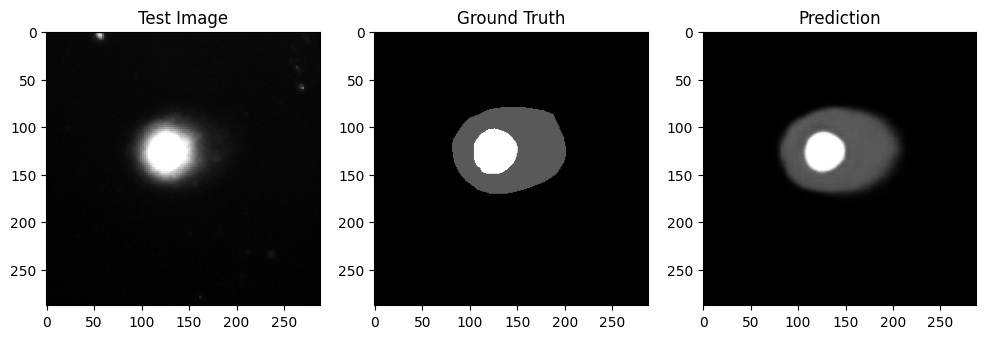

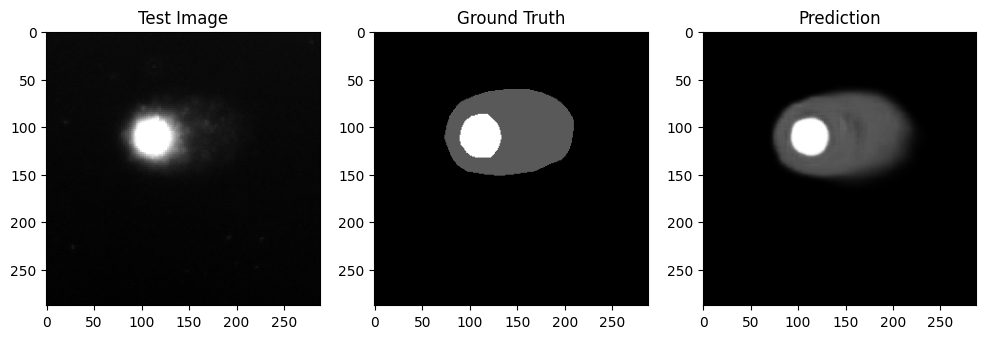

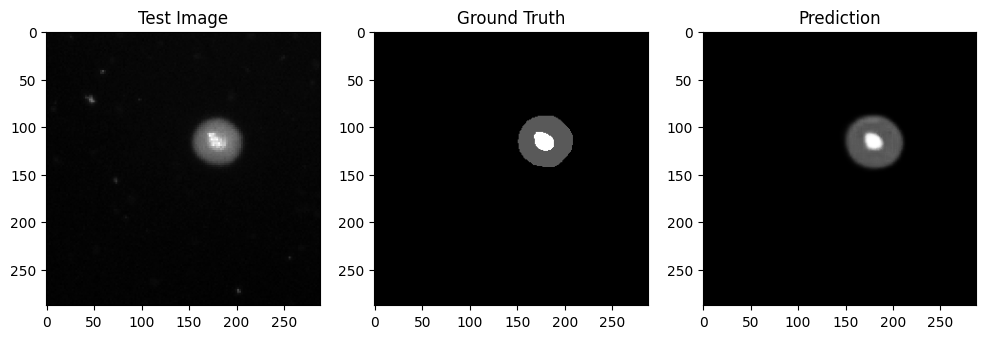

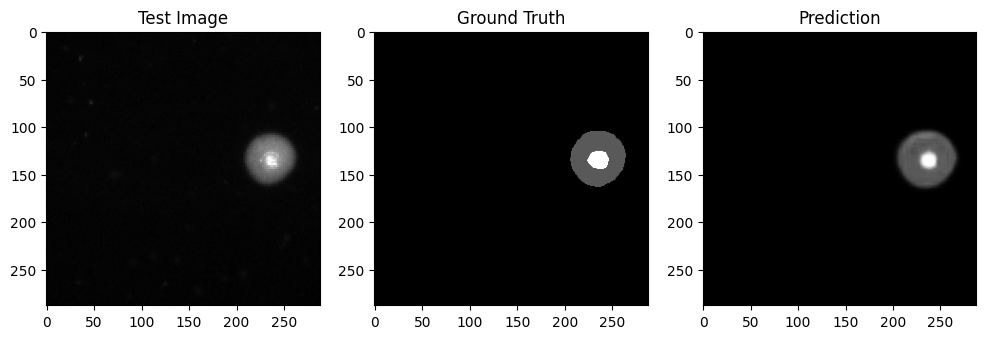

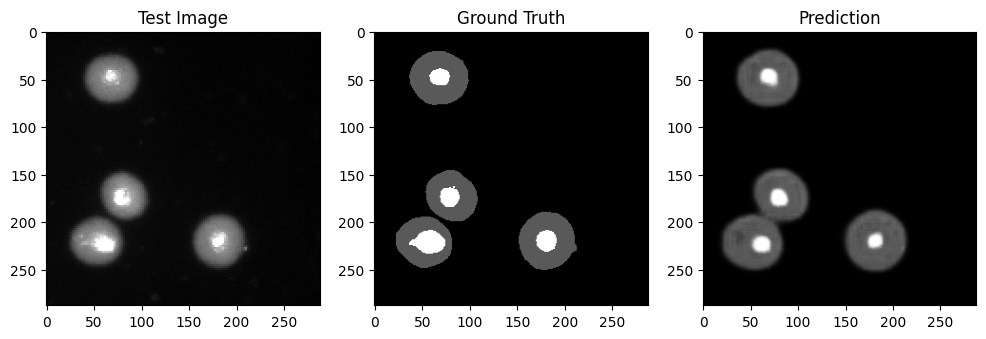

In [12]:
# 12. Display results on test data
def display_results(test_images, test_labels, model):
    predictions = model.predict(test_images)
    for i in range(5):  # Display 5 examples
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Test Image")
        plt.imshow(test_images[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(test_labels[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(predictions[i].squeeze(), cmap='gray')

        plt.show()

display_results(test_images, test_labels, model)

In [13]:
# 13. Function to pad images 
def pad_image(image, target_size):
    pad_h = (target_size[0] - image.shape[0]) // 2
    pad_w = (target_size[1] - image.shape[1]) // 2
    
    padded_image = np.pad(image, ((pad_h, target_size[0] - image.shape[0] - pad_h),
                                  (pad_w, target_size[1] - image.shape[1] - pad_w),
                                  (0, 0)), mode='constant', constant_values=0)
    return padded_image


In [14]:
# 14.Function to display predictions on final test images
def display_final_results(final_test_images, final_test_labels, model, start, end):
    # Calculate the target size (next multiple of 16)
    target_size = ((1038 // 16 + 1) * 16, (1388 // 16 + 1) * 16)
    
    final_test_images_padded = np.array([pad_image(img, target_size) for img in final_test_images])
    final_predictions_padded = model.predict(final_test_images_padded[start:end])
    final_predictions = [pred[:1038, :1388, :] for pred in final_predictions_padded]
    x = 0

    for i in range(start, end):  
        plt.figure(figsize=(12, 4))
        print(i)

        plt.subplot(1, 3, 1)
        plt.title("Test Image")
        plt.imshow(final_test_images[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(final_test_labels[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(final_predictions[x].squeeze(), cmap='gray')
        x = x + 1
        
        plt.show()

E0000 00:00:1734324590.494392   22378 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734324590.603468   22378 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734324590.718628   22378 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734324590.825553   22378 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734324590.940675   22378 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
0


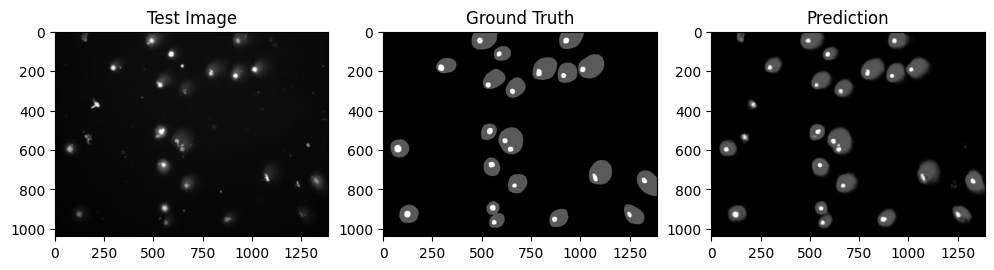

1


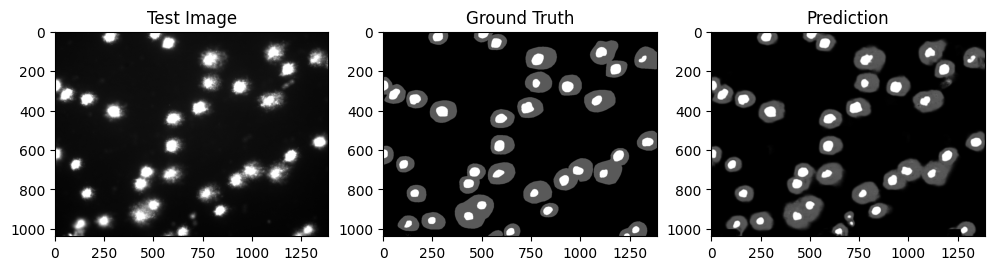

2


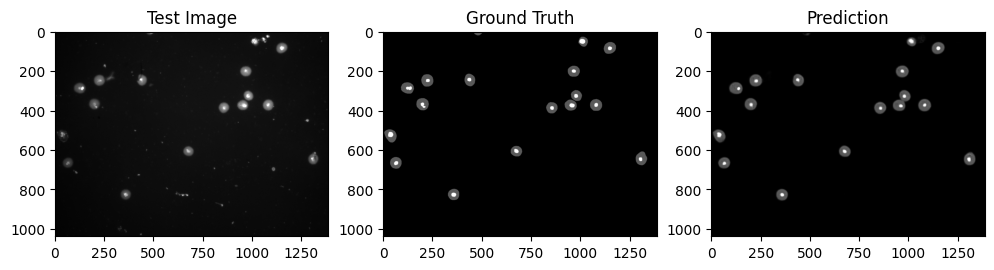

3


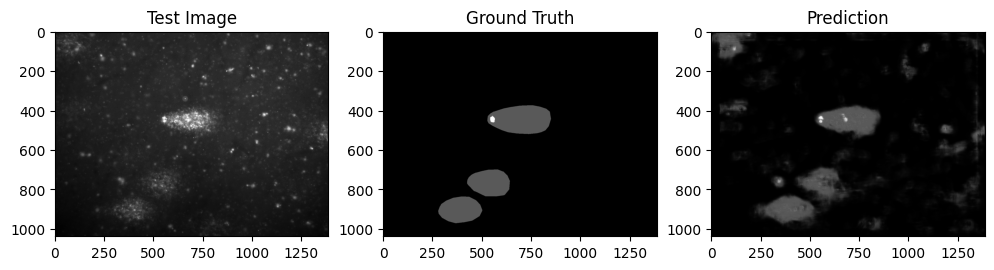

4


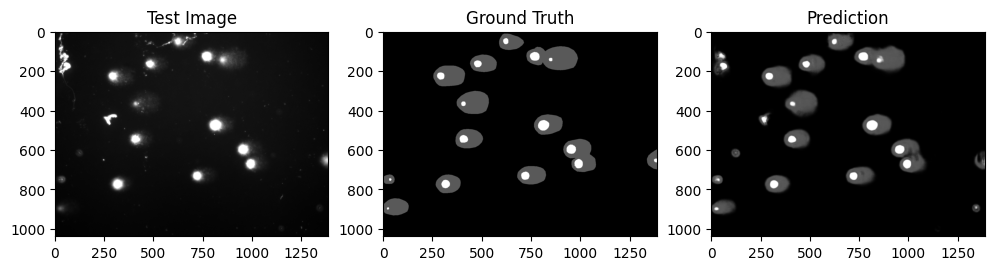

In [15]:
# 15. Display results
final_test_images, final_test_labels = load_images_and_labels(final_test_images_dir, final_test_labels_dir, image_size=(1038, 1388))
# Predict results for a subgroup of the final test images as per memory capacity
display_final_results(final_test_images, final_test_labels, model, 0, 5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5


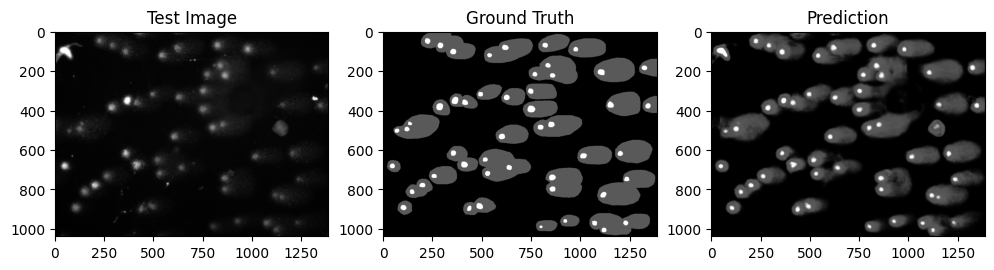

6


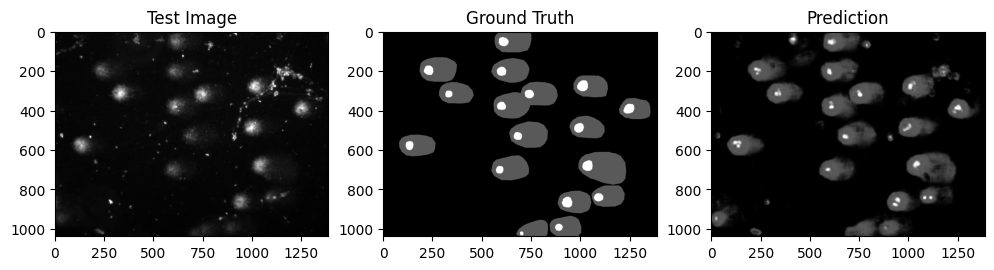

7


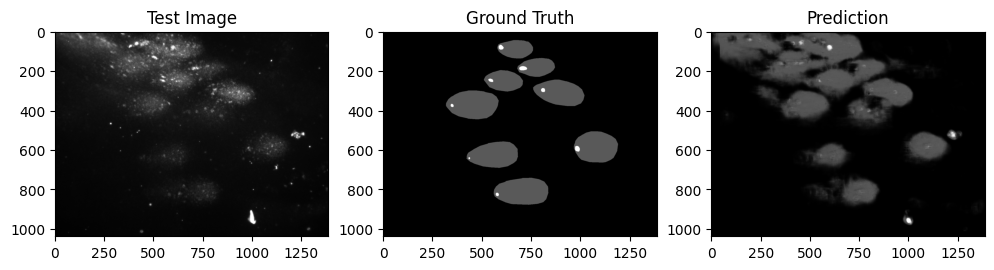

8


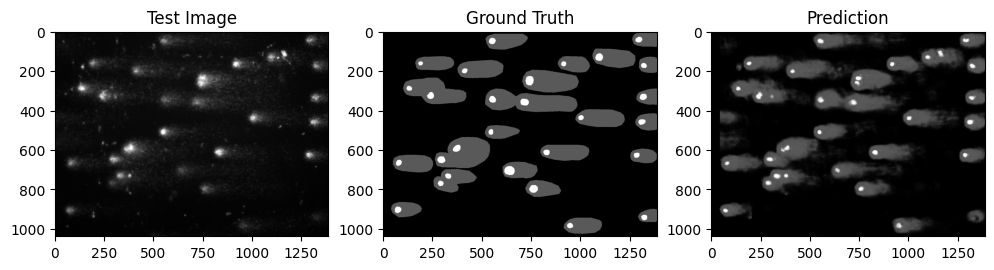

9


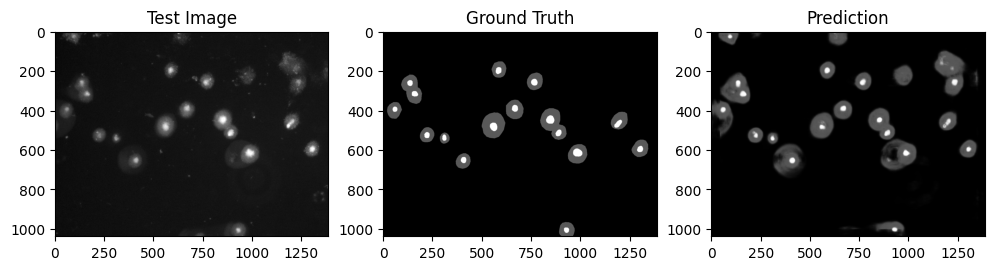

In [16]:
# Predict results for the remainder images
display_final_results(final_test_images, final_test_labels, model, 5, 10)